In [1]:
from DataPreprocessing.python.Data import *

import pandas as pd
import numpy as np


## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

In [2]:
rootData = Data("/Users/czkaiweb/Research/ErdosBootCamp/Project/ProjectData/Root_Insurance_data.csv")
rootData.loadData()
rootData.factorizeData()
rootData.splitData(fraction=[0.5,0.3,0.2],random_seed=42)
data_train = rootData.getTrainDataCopy()
data_validation = rootData.getValidationDataCopy()
data_test  = rootData.getTestDataCopy()

In [3]:
print(data_train.head())
print(data_validation.head())
print(data_test.head())

      Currently Insured  Number of Vehicles  Number of Drivers  \
6252                  0                   1                  1   
4684                  0                   3                  2   
1731                  1                   2                  2   
4742                  1                   3                  1   
4521                  1                   3                  1   

      Marital Status   bid  rank  click  policies_sold  
6252               1  10.0     1   True              1  
4684               0  10.0     3  False              0  
1731               0  10.0     4  False              0  
4742               1  10.0     4  False              0  
4521               0  10.0     4  False              0  
      Currently Insured  Number of Vehicles  Number of Drivers  \
3115                  0                   1                  2   
5295                  0                   1                  1   
5439                  1                   2                  1 

In [4]:
X_train = data_train.iloc[:, 0:4].values
y_train = data_train.iloc[:, -1].values
click_train = data_train.iloc[:, -2].values

X_validation = data_validation.iloc[:, 0:4].values
y_validation = data_validation.iloc[:, -1].values
click_validation = data_validation.iloc[:, -2].values

X_test = data_test.iloc[:, 0:4].values
y_test = data_test.iloc[:, -1].values
click_test = data_test.iloc[:, -2].values

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)
X_test = sc.transform(X_test)

In [6]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=42)
regressor.fit(X_train, y_train)
y_vpred = regressor.predict(X_validation)

In [7]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_validation, y_vpred))
print('Mean Squared Error:', metrics.mean_squared_error(y_validation, y_vpred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_validation, y_vpred)))

Mean Absolute Error: 0.12901597473459112
Mean Squared Error: 0.06591558714485009
Root Mean Squared Error: 0.2567403107126929


In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [9]:
fpr, tpr, thresholds = roc_curve(y_validation, y_vpred, pos_label=1)

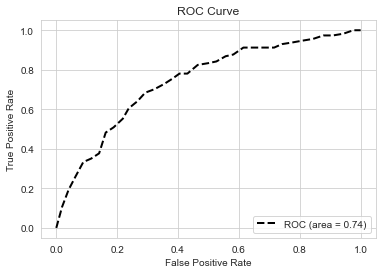

In [10]:
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
def getReward(regressor, reward, threshold, Xs, ys, clicks):
    total_reward = 0
    for index,X in enumerate(Xs):
        if regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 1 and clicks[index] == True:
            total_reward += reward
        elif regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 0 and clicks[index] == True:
            total_reward += -10
    return total_reward

def getROI(reward, threshold, y_preds, ys, clicks):
    stack1 = np.stack([ys, y_preds])
    stack  = np.concatenate((stack1, [clicks]),axis=0)
    stack = stack.T
    
    gain_index = np.logical_and(stack[:,0] == 1,stack[:,1]> threshold)
    gain_stack = stack[gain_index,:]
    gain = len(gain_stack)*reward
    cost_index = np.logical_and(stack[:,2] == True,stack[:,1]> threshold)
    cost_stack = stack[cost_index,:]
    cost = len(cost_stack)*10
    return (gain-cost+len(gain_stack)*10)/(cost+0.001), len(gain_stack), gain-cost+len(gain_stack)*10

In [12]:
reward_list = [1,2,3,4,5,6,7,8,9,10,20,30,40]
reward_buffers = {}
nSold_buffers = {}
gain_buffers = {}
thresholds = np.arange(0, 0.3, 0.005).tolist() +  np.arange(0.3, 1.9, 0.8).tolist()

for reward in reward_list:
    reward_buffers[reward]=[]
    nSold_buffers[reward] = []
    gain_buffers[reward] = []
    buffer_reward = []
    buffer_sold = []
    buffer_gain = []
    for threshold in thresholds:
        ROI, nSold, gain = getROI(reward,threshold, y_vpred, y_validation, click_validation)
        buffer_reward.append(ROI)
        buffer_sold.append(nSold)
        buffer_gain.append(gain)
    reward_buffers[reward]=buffer_reward
    nSold_buffers[reward]=buffer_sold
    gain_buffers[reward]=buffer_gain
        


<Figure size 432x288 with 0 Axes>

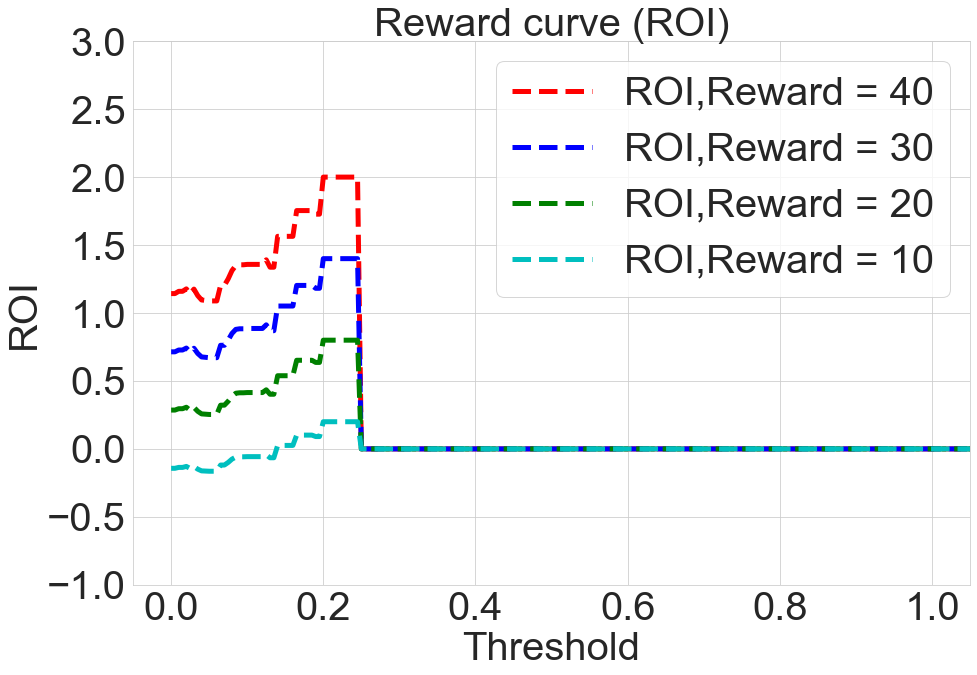

In [13]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, reward_buffers[40], 'r--',lw=5, label = "ROI,Reward = 40")
plt.plot(thresholds, reward_buffers[30], 'b--',lw=5, label = "ROI,Reward = 30")
plt.plot(thresholds, reward_buffers[20], 'g--',lw=5, label = "ROI,Reward = 20")
plt.plot(thresholds, reward_buffers[10], 'c--',lw=5, label = "ROI,Reward = 10")
 
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=40)
plt.ylim([-1.0, 3.0])
plt.yticks(fontsize=40)
plt.xlabel('Threshold',fontsize=40)
plt.ylabel('ROI', fontsize=40)
plt.title('Reward curve (ROI)', fontsize=40)
plt.legend(loc="upper right",prop={'size': 40})
plt.show()

<Figure size 432x288 with 0 Axes>

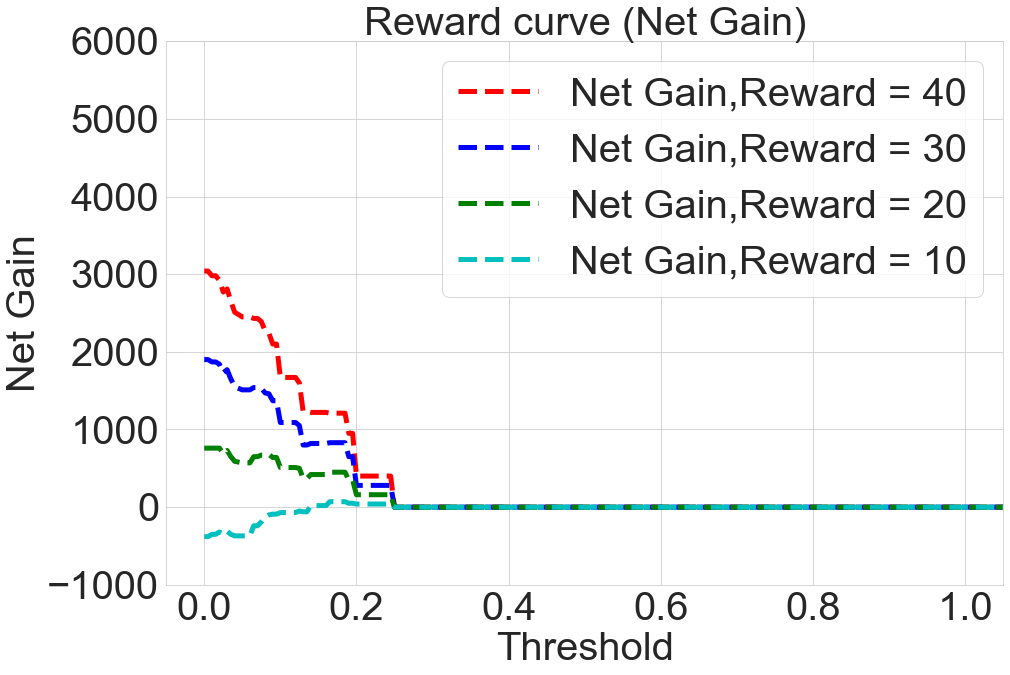

In [14]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, gain_buffers[40], 'r--',lw=5, label = "Net Gain,Reward = 40")
plt.plot(thresholds, gain_buffers[30], 'b--',lw=5, label = "Net Gain,Reward = 30")
plt.plot(thresholds, gain_buffers[20], 'g--',lw=5, label = "Net Gain,Reward = 20")
plt.plot(thresholds, gain_buffers[10], 'c--',lw=5, label = "Net Gain,Reward = 10")
 
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=40)
plt.ylim([-1000.0, 6000.0])
plt.yticks(fontsize=40)
plt.xlabel('Threshold',fontsize=40)
plt.ylabel('Net Gain',fontsize=40)
plt.title('Reward curve (Net Gain)',fontsize=40)
plt.legend(loc="upper right",prop={'size': 40})
plt.show()

<Figure size 432x288 with 0 Axes>

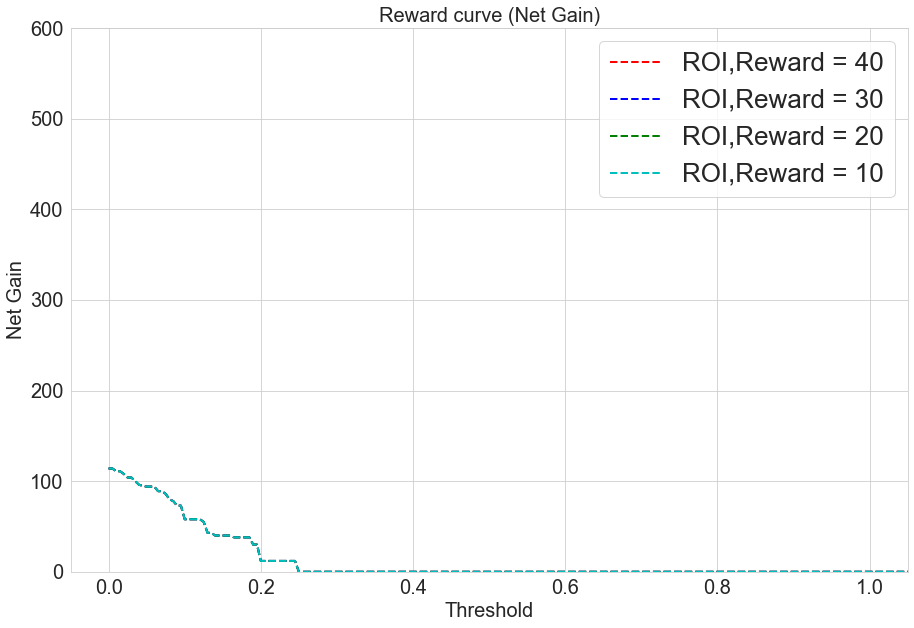

In [15]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, nSold_buffers[40], 'r--',lw=2, label = "ROI,Reward = 40")
plt.plot(thresholds, nSold_buffers[30], 'b--',lw=2, label = "ROI,Reward = 30")
plt.plot(thresholds, nSold_buffers[20], 'g--',lw=2, label = "ROI,Reward = 20")
plt.plot(thresholds, nSold_buffers[10], 'c--',lw=2, label = "ROI,Reward = 10")
 
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=20)
plt.ylim([-0.0, 600.0])
plt.yticks(fontsize=20)
plt.xlabel('Threshold',fontsize=20)
plt.ylabel('Net Gain',fontsize=20)
plt.title('Reward curve (Net Gain)',fontsize=20)
plt.legend(loc="upper right",prop={'size': 26})
plt.show()

In [ ]:
i_best_threshold = reward_buffer.index(max(reward_buffer))
best_threshold  = thresholds[i_best_threshold]
print("best_threshold = {}".format(best_threshold))

In [ ]:
reward = getReward(regressor,best_threshold,X_test,y_test,click_test)
print("reward = {}".format(reward))
reward_naive = getReward(regressor,0,X_test,y_test,click_test)
print("naive reward = {}".format(reward_naive))

In [22]:
y_pred = regressor.predict(X_test)

ROI, sold, netgain = getROI(40, 0, y_pred, y_test, click_test)
for threshold in np.arange(0, 0.3, 0.025).tolist():
    ROI_new, sold_new, netgain_new = getROI(40, threshold, y_pred, y_test, click_test)
    print("Threshold:{:.3}  ROI:{:.1%} Sold:{:.1%} NetGain:{:.1%}".format(threshold,ROI_new/(ROI+0.001)-1,sold_new/(sold+0.001)-1,netgain_new/(netgain+0.001)-1))

Threshold:0.0  ROI:-0.1% Sold:-0.0% NetGain:-0.0%
Threshold:0.025  ROI:7.9% Sold:-4.2% NetGain:-0.7%
Threshold:0.05  ROI:11.2% Sold:-12.8% NetGain:-8.5%
Threshold:0.075  ROI:19.0% Sold:-21.9% NetGain:-15.5%
Threshold:0.1  ROI:23.1% Sold:-54.2% NetGain:-49.7%
Threshold:0.125  ROI:26.3% Sold:-57.6% NetGain:-53.0%
Threshold:0.15  ROI:35.2% Sold:-65.3% NetGain:-60.4%
Threshold:0.175  ROI:31.2% Sold:-71.5% NetGain:-67.9%
Threshold:0.2  ROI:20.2% Sold:-92.7% NetGain:-92.1%
Threshold:0.225  ROI:20.2% Sold:-92.7% NetGain:-92.1%
Threshold:0.25  ROI:-100.0% Sold:-100.0% NetGain:-100.0%
Threshold:0.275  ROI:-100.0% Sold:-100.0% NetGain:-100.0%
